<a href="https://colab.research.google.com/github/geoffwoollard/ece1512_project/blob/master/nb/cryo_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
- GPU to TPU? https://www.kdnuggets.com/2019/03/train-keras-model-20x-faster-tpu-free.html
- [add gussian noise](https://towardsdatascience.com/noise-its-not-always-annoying-1bd5f0f240f)
- window particles

# Goal
* implement transfer leaning (using pretrained architecture)

# Resources
* [Transfer Learning in Keras with Computer Vision Models](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)
* [Deep Learning using Transfer Learning -Python Code for ResNet50](https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38)


In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
%cd /content/drive/My\ Drive/mbp/mohammad/ece1512_project
import mrc, fit_generator_helper, customizable_deep_network
import importlib
importlib.reload(fit_generator_helper)


/content/drive/My Drive/mbp/mohammad/ece1512_project


Using TensorFlow backend.


<module 'fit_generator_helper' from '/content/drive/My Drive/mbp/mohammad/ece1512_project/fit_generator_helper.py'>

In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os, shutil

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

### Load the data set

In [0]:
labels = []
files = []
#label_d = {'J977':0,'J978':1,'J979':2} # protomer, side, top
label_d = {'J1028':0,'J930':1} # +/- micelle. different underlying picks
for jdir in label_d.keys():
  slow_dir = '/content/drive/My Drive/mbp/mohammad/ece1512_project/data/ouhn_Data1_P1/%s'% jdir
  fast_dir = '/%s'% jdir
  if not os.path.exists(fast_dir):
    shutil.copytree(slow_dir,fast_dir) #!cp -r /content/drive/My\ Drive/mbp/mohammad/ece1512_project/data/ouhn_Data1_P1/J1028 /
  for fname in glob('/%s/downsample/*mrc' % jdir): #glob('/content/drive/My Drive/mbp/mohammad/ece1512_project/data/ouhn_Data1_P1/%s/downsample/*mrc' % jdir): 
    files.append(fname)
    labels.append(label_d[jdir])


In [16]:
df = fit_generator_helper.parse_files(files,labels)

header = mrc.read_header(df['fname'].iloc[0])
nx,ny = header['nx'], header['ny']

n = int(df['class'].value_counts().min())
df0 = df.loc[(df['class'] == 0)].sample(n)
df1 = df.loc[(df['class'] == 1)].sample(n)
#df2 = df.loc[(df['class'] == 2)].sample(n)

df = pd.concat([df0,df1])
#df = pd.concat([df0,df1,df2])


df = df.sample(df.shape[0])

df['class'].value_counts() 

1    25158
0    25158
Name: class, dtype: int64

In [18]:
# test/train split
val_n = int(0.02*df.shape[0]) 
df_val = df.iloc[-val_n:]
df = df.iloc[:-val_n]
df.shape, df_val.shape

((49310, 3), (1006, 3))

In [19]:
%%time
# 12 min 3.4k
# 13 min 3.4k
# 33s 100 
# 2.5s/3.25min 706
X_val,Y_val = fit_generator_helper.XY_from_df_batch(df_val,nx=nx,ny=ny,num_classes=df['class'].unique().size)
print(X_val.shape)

(1006, 64, 64, 1)
CPU times: user 131 ms, sys: 42.3 ms, total: 173 ms
Wall time: 178 ms


# Model

In [20]:
img_height,img_width = nx,ny 
num_classes = df['class'].unique().size
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
#base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,1))
input_shape=(img_height,img_width,3)
restnet = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= input_shape)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [0]:
output = restnet.layers[-1].output
output = Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 28,045,697
Trainable params: 4,457,985
Non-trainable params: 23,587,712
__________________________________

# 1 -> 3 channel
* the images are black and white (1 channel). However some architectures have pretrained weights on 3 channel RGB images. We can duplicate each batch in  `fit_generator_helper.XY_from_df_batch`
* There are many ways to duplicate data. `np.concatenate` seems comes out the fastest in some [benchmarks](https://stackoverflow.com/questions/39463019/how-to-copy-numpy-array-value-into-higher-dimensions). However in my benchmarks `np.stack` and `np.concatenate` are the fastest, but it depends on the batch size.


In [0]:
df_batch = df.iloc[:20]
dict_list = df_batch.to_dict('records')
x_train = fit_generator_helper.read_particles(dict_list,nx,ny)
X = x_train[:,:,:,np.newaxis]
X.shape

(20, 64, 64, 1)

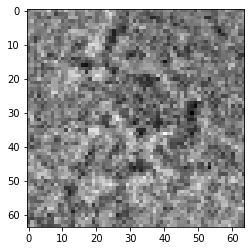

In [0]:
plt.imshow(X[0,:,:,0],cmap='gray')

In [0]:
X3 = np.stack([x_train]*3, -1)
X3.shape

(20, 64, 64, 3)

True

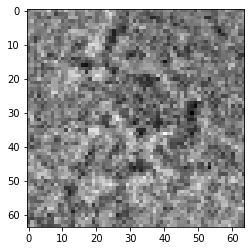

In [0]:
plt.imshow(X3[0,:,:,0:3].mean(axis=-1),cmap='gray')
np.allclose(X3[0,:,:,0:3].mean(axis=-1),X3[0,:,:,0])

In [0]:
df_batch = df.iloc[:5]
dict_list = df_batch.to_dict('records')
x_train = fit_generator_helper.read_particles(dict_list,nx,ny)

%timeit -n 1000 np.concatenate([x_train[:,:,:,np.newaxis]]*3, axis=-1)
%timeit -n 1000 np.repeat(x_train[..., np.newaxis], 3, axis=-1)
%timeit -n 1000 np.dstack([x_train]*3) # not right shape. not sure how to reshape
%timeit -n 1000 np.stack([x_train]*3, -1)
%timeit -n 1000 np.tile(x_train[..., np.newaxis], 3)

1000 loops, best of 3: 76.6 µs per loop
1000 loops, best of 3: 288 µs per loop
1000 loops, best of 3: 72.6 µs per loop
1000 loops, best of 3: 87.5 µs per loop
1000 loops, best of 3: 291 µs per loop


In [0]:
df_batch = df.iloc[:20]
dict_list = df_batch.to_dict('records')
x_train = fit_generator_helper.read_particles(dict_list,nx,ny)

%timeit -n 1000 np.concatenate([x_train[:,:,:,np.newaxis]]*3, axis=-1)
%timeit -n 1000 np.repeat(x_train[..., np.newaxis], 3, axis=-1)
%timeit -n 1000 np.dstack([x_train]*3)
%timeit -n 1000 np.stack([x_train]*3, -1)
%timeit -n 1000 np.tile(x_train[..., np.newaxis], 3)

1000 loops, best of 3: 345 µs per loop
1000 loops, best of 3: 1.03 ms per loop
1000 loops, best of 3: 236 µs per loop
1000 loops, best of 3: 333 µs per loop
1000 loops, best of 3: 983 µs per loop


In [0]:
df_batch = df.iloc[:50]
dict_list = df_batch.to_dict('records')
x_train = fit_generator_helper.read_particles(dict_list,nx,ny)

%timeit -n 1000 np.concatenate([x_train[:,:,:,np.newaxis]]*3, axis=-1)
%timeit -n 1000 np.repeat(x_train[..., np.newaxis], 3, axis=-1)
%timeit -n 1000 np.dstack([x_train]*3)
%timeit -n 1000 np.stack([x_train]*3, -1)
%timeit -n 1000 np.tile(x_train[..., np.newaxis], 3)

1000 loops, best of 3: 964 µs per loop
1000 loops, best of 3: 2.5 ms per loop
1000 loops, best of 3: 499 µs per loop
1000 loops, best of 3: 742 µs per loop
1000 loops, best of 3: 2.38 ms per loop


In [0]:
%cd /content/drive/My\ Drive/mbp/mohammad/ece1512_project
import mrc, fit_generator_helper, customizable_deep_network
import importlib
importlib.reload(fit_generator_helper)


/content/drive/My Drive/mbp/mohammad/ece1512_project


<module 'fit_generator_helper' from '/content/drive/My Drive/mbp/mohammad/ece1512_project/fit_generator_helper.py'>

In [0]:
X_batch, Y_batch = fit_generator_helper.XY_from_df_batch(df.iloc[:5],
                                      nx,
                                      ny,
                                      do_1to3channel=True
    
)
X_batch.shape, Y_batch.shape

((5, 64, 64, 3), (5,))

In [0]:
fit_generator_helper.image_loader(df.sample(4),
                                  do_augment=True,
                                  batch_size=batch_size,
                                  nx=nx,ny=ny,
                                  num_classes=df['class'].unique().size,
                                  do_1to3channel=True
                                  )

<generator object image_loader at 0x7f3cfc286780>

We also need to reshape the Y data

In [0]:
num_classes = 2
Y = fit_generator_helper.to_categorical(df_batch['class'].values, num_classes=num_classes,dtype='int')
df_batch['class'].values

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1])

# Train

In [0]:
batch_size = 20 # do not put this too large. 100 too big. 50 getting big, perhaps can go bigger. 20 ok
n=df.shape[0]
steps_per_epoch = np.floor(df.sample(n).shape[0] / batch_size) # 110 for 11k particles
steps_per_epoch

2465.0

In [0]:
from sklearn.metrics import confusion_matrix
from datetime import datetime
dateTimeObj = datetime.now()
!mkdir /keras_models

In [0]:
def XY_to_3channel(X,Y):
  X3 = np.stack([X[:,:,:,0]]*3, -1)
  Y3 = np.argmax(Y,axis=1)
  return(X3,Y3)
XY_aug_list = [fit_generator_helper.batch_image_augment(X_val,Y_val,batch_size=X_val.shape[0],rotation_range=180) for x in range(1)]
X, Y = XY_aug_list[0]
X3, Y3 = XY_to_3channel(X,Y)
model.evaluate(X3, Y3)

1006/1006 [==============================] - 1s 705us/step


[0.7480953226743589, 0.5089462995529175]

In [0]:
model_fname = '/keras_models/micelle_aug_rn50_pretrainedin'
do_1to3channel=True
for epoch in range(40):
    print('actual epoch %i' % epoch)
    model.fit_generator(fit_generator_helper.image_loader(df.sample(n),
                                                          do_augment=True,
                                                          batch_size=batch_size,
                                                          nx=nx,ny=ny,
                                                          num_classes=df['class'].unique().size,
                                                          do_1to3channel=do_1to3channel,
                                                          ),
                        steps_per_epoch=steps_per_epoch, # steps_per_epoch is number of batches per epoch
                        epochs=1,
                        )
    
    XY_aug_list = [fit_generator_helper.batch_image_augment(X_val,Y_val,batch_size=X_val.shape[0],rotation_range=180) for x in range(1)]
    for X, Y in XY_aug_list:
      X, Y = XY_to_3channel(X,Y)
      scores = model.evaluate(X, Y)
      print ('epoch %s' % epoch, "Loss = " + str(scores[0]), "Test Accuracy = " + str(scores[1]))
      #model.save(model_fname+dateTimeObj.strftime("%Y%m%d-%H%M%S")+'_ep%i.h5'%epoch)
      Y_pred = model.predict(X)
      print(confusion_matrix(Y, Y_pred > 0.5))

    

actual epoch 0
Epoch 1/1
1006/1006 [==============================] - 1s 685us/step
epoch 0 Loss = 0.7078211091858729 Test Accuracy = 0.49701789021492004
[[ 95 409]
 [ 97 405]]
actual epoch 1
Epoch 1/1
1006/1006 [==============================] - 1s 681us/step
epoch 1 Loss = 0.7059611668643611 Test Accuracy = 0.48906561732292175
[[311 193]
 [321 181]]
actual epoch 2
Epoch 1/1
1006/1006 [==============================] - 1s 684us/step
epoch 2 Loss = 0.7218612874478516 Test Accuracy = 0.5218687653541565
[[ 65 439]
 [ 42 460]]
actual epoch 3
Epoch 1/1
1006/1006 [==============================] - 1s 678us/step
epoch 3 Loss = 0.7059369870493 Test Accuracy = 0.5357853174209595
[[104 400]
 [ 67 435]]
actual epoch 4
Epoch 1/1
1006/1006 [==============================] - 1s 709us/step
epoch 4 Loss = 0.7559979073332982 Test Accuracy = 0.4990059733390808
[[ 15 489]
 [ 15 487]]
actual epoch 5
Epoch 1/1
1006/1006 [==============================] - 1s 678us/step
epoch 5 Loss = 0.7547148416340944 Tes

In [0]:
model_fname = '/keras_models/micelle_aug_rn50_pretrainedin'
do_1to3channel=True
for epoch in range(40,41):
    print('actual epoch %i' % epoch)
    model.fit_generator(fit_generator_helper.image_loader(df.sample(n),
                                                          do_augment=True,
                                                          batch_size=batch_size,
                                                          nx=nx,ny=ny,
                                                          num_classes=df['class'].unique().size,
                                                          do_1to3channel=do_1to3channel,
                                                          ),
                        steps_per_epoch=steps_per_epoch, # steps_per_epoch is number of batches per epoch
                        epochs=1,
                        )
    
    XY_aug_list = [fit_generator_helper.batch_image_augment(X_val,Y_val,batch_size=X_val.shape[0],rotation_range=180) for x in range(1)]
    for X, Y in XY_aug_list:
      X, Y = XY_to_3channel(X,Y)
      scores = model.evaluate(X, Y)
      print ('epoch %s' % epoch, "Loss = " + str(scores[0]), "Test Accuracy = " + str(scores[1]))
      #model.save(model_fname+dateTimeObj.strftime("%Y%m%d-%H%M%S")+'_ep%i.h5'%epoch)
      Y_pred = model.predict(X)
      print(confusion_matrix(Y, Y_pred > 0.5))

    

actual epoch 40
Epoch 1/1
1006/1006 [==============================] - 1s 674us/step
epoch 40 Loss = 0.790411197286003 Test Accuracy = 0.5009940266609192
[[  2 502]
 [  0 502]]



|jobs | pix | train acc (%) | val acc (%) | epochs|notes|
|-|-|-|-|-|-|
|J1028,J930. 25k each. +/- micelle. different underlying picks. `micelle_aug_rn50_pretrainedin`|64| 58.2 ep 20, 59.4 ep 30, 60.0 ep 40 | 50 for all epochs up to 40, pretty much all being predicted as same class  |40|aug. resnet 50 imagenet weights. copied 1 to 3 channels|
